# EDA (Exploratory Data Analysis)
EDA is a method of exploring through a given set of data, finding and cleaning outliers, and ultimately preparing the data for ML model training.  In contrast to many public/open datasets, this dataset is fairly clean and consistent, possibly because of legal oversight.  

Regardless, I will thankfully be able to focus more on analyzing the data than fixing and cleaning it.

## A Brief Aside for Unexpected Empathy
Having turned the corner on much of the EDA, I suddenly understand why officers are so reluctant to take actions because of the "paperwork".  

At 81 discrete data points which need to be vetted and validated, a couple of stop and frisk interactions could easily take up an entire afternoon of data entry.  I say this after seeing the [astronomical stop and frisk numbers prior to 2017](https://datacollaborativeforjustice.org/dashboard-sqf/) and reviewing the data from the same period.  There's orders of magnitude less data collected from that period despite a stop rate of up to 25k stops / 100,000 persons, or ~600,000 total stops in 2016 vs the ~25,000 stops in 2024*.  

One of the primary drivers of keeping these rates as low as they are might very well be the raw data entry time required to process that many events.

But, I digress....

# Unsupervised Learning Update
Having turned the corner on munging all of the data from 2021-24 together, this data was not clean and often times seemed outright performative.  I say that in context of the report in the references stating that ~40% of all stops aren't even recorded in this dataset.



In [1]:
import numpy as np
import pandas as pd
from utils.model_training import prepare_model_features, visualize_features
import seaborn as sns



In [2]:
df = pd.read_csv(
    "./data/processed/stop-and-frisk.csv",
    parse_dates=["STOP_FRISK_DATE"],  
)
# df.info()

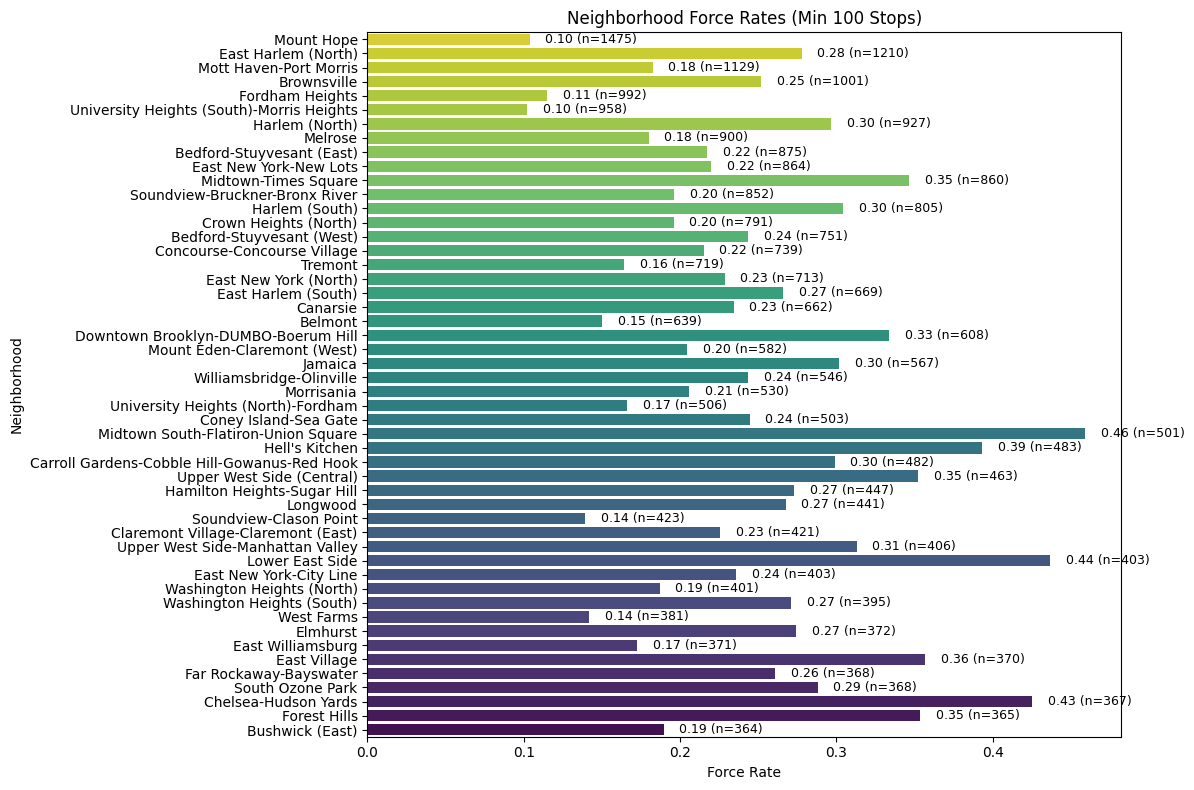

In [ ]:
# Todo: cleanup + reorder

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
neighborhood_force = df[['NEIGHBORHOOD']].dropna()
neighborhood_force_rates = df.groupby('NEIGHBORHOOD')['OFFICER_USED_FORCE'].mean()
df['NEIGHBORHOOD_FORCE_RATE'] = df['NEIGHBORHOOD'].map(neighborhood_force_rates)

neighborhood_force = df.groupby('NEIGHBORHOOD')['NEIGHBORHOOD_FORCE_RATE'].mean().sort_values(ascending=False)

top_n = 50
neighborhood_force_top = neighborhood_force.nlargest(top_n)

MIN_STOPS = 100  

# 1. Calculate stop counts per neighborhood
neighborhood_stats = df.groupby('NEIGHBORHOOD').agg(
    TOTAL_STOPS=('NEIGHBORHOOD_FORCE_RATE', 'count'),
    FORCE_RATE=('NEIGHBORHOOD_FORCE_RATE', 'mean')
)

# 2. Filter neighborhoods meeting the threshold
qualified_neighborhoods = neighborhood_stats[neighborhood_stats['TOTAL_STOPS'] >= MIN_STOPS]
qualified_neighborhoods = qualified_neighborhoods.sort_values('TOTAL_STOPS', ascending=False)
qualified_neighborhoods = qualified_neighborhoods.nlargest(top_n, ['TOTAL_STOPS'])
# 3. Create the visualization
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='FORCE_RATE',
    y=qualified_neighborhoods.index,
    data=qualified_neighborhoods,
    palette="viridis_r",
    hue=qualified_neighborhoods.index,
    # legend=False,
    order=qualified_neighborhoods.index  # Maintain sorted order
)

# 4. Annotate with both rate and count
for i, (rate, count) in enumerate(zip(qualified_neighborhoods['FORCE_RATE'], 
                                   qualified_neighborhoods['TOTAL_STOPS'])):
    ax.text(rate + 0.01, i, 
            f'{rate:.2f} (n={count})', 
            va='center', 
            fontsize=9)

plt.title(f'Neighborhood Force Rates (Min {MIN_STOPS} Stops)')
plt.xlabel('Force Rate')
plt.ylabel('Neighborhood')
plt.tight_layout()